In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import pandas as pd


import tensorflow as tf
import tf_data

%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    len(tf.config.list_physical_devices('GPU')) > 0))
      
if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")
else:
    strategy = tf.distribute.OneDeviceStrategy("cpu:0")

version=2.3.0, CUDA=True, GPU=True


In [3]:
!nvidia-smi

Fri Sep 17 16:50:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:07.0 Off |                    0 |
| N/A   54C    P0    29W /  70W |    258MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Test training

In [4]:
import tf_data_jet
from model import *
from plotting import * 

In [5]:
models_path = "/eos/user/p/psimkina/evaluation/jet_model/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
# Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
#                             'n_seed_features','batch_size','lr_decay','lr',
#                             'hidden_dim_input','hidden_dim_coord', 'hidden_dim_id',
#                             'n_layers_input', 'n_layers_id', 'n_layers_coord',
#                            'distance_dim','num_conv','dropout','convlayer',
#                            'nclass_labels', 'opt'])
Args = namedtuple('args', [ 'models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'activation', 
                           'output_dim_rechits', 'output_dim_nodes', 'output_dim_gconv', 'output_dim_sa_clclass',
                           'output_dim_sa_windclass','output_dim_sa_enregr','coord_dim','coord_dim_sa','nconv_rechits','nconv', 
                           'layers_input','layers_clclass','layers_windclass','layers_enregr', 'n_windclasses',
                          'dropout','l2_reg','loss_clusters','loss_window','loss_softF1','loss_en_resol','loss_en_softF1','loss_en_regr','softF1_beta'])


args = Args( 
models_path = models_path,
load = False,
initial_epoch = 0,
nepochs = 200,
ntrain = 1000000,
nval = 300000,
lr_decay = 0.,
lr = 3e-3,
batch_size = 512,
opt='adam',
    
activation = tf.keras.activations.elu,
output_dim_rechits = 25,
output_dim_nodes = 256,
output_dim_gconv = 256,
output_dim_sa_clclass = 256,
output_dim_sa_windclass = 256,
output_dim_sa_enregr = 256,
coord_dim = 3,
coord_dim_sa = 15,
nconv_rechits = 4,
nconv = 3,
layers_input = [256,128,128,64],
layers_clclass = [256,128,128,64],
layers_windclass = [128,64,64],
layers_enregr = [256,128,128,64],
n_windclasses = 3, 
dropout = 0.1,
l2_reg = True, 
    
loss_clusters= 100,
loss_window=  1., 
loss_softF1=  1.,
loss_en_resol =  0., 
loss_en_softF1 = 100,
loss_en_regr = 0.05,
softF1_beta = 1.5
)

### Dataset loading

In [6]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number


if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print(outdir)

/eos/user/p/psimkina/evaluation/jet_model/run_31


In [7]:
data_path_train = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v11/training/calo_matched/*.proto",
                   "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v11/training/calo_matched/*.proto",
                   "jet_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/jets/recordio_allinfo_v11/training/calo_matched/*.proto"
                 # "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v10/training/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
                  }
data_path_test = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v11/testing/calo_matched/*.proto",
                   "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v11/testing/calo_matched/*.proto",
                  "jet_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/jets/recordio_allinfo_v11/testing/calo_matched/*.proto"
#                   "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v10/testing/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/testing/no_calo_matched/*.proto"
                  }

In [8]:
features_dict = {

"cl_features" : [ "en_cluster","et_cluster",
            "cluster_eta", "cluster_phi", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
             "cluster_den_seed","cluster_det_seed",
            
#             "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
#             "cl_sigmaIphiIphi","cl_swissCross","cl_etaWidth","cl_phiWidth"
                 
            "cl_nxtals" ],
    

 "window_features" : [ "max_en_cluster","max_et_cluster","max_deta_cluster","max_dphi_cluster","max_den_cluster","max_det_cluster",
                    "min_en_cluster","min_et_cluster","min_deta_cluster","min_dphi_cluster","min_den_cluster","min_det_cluster",
                    "mean_en_cluster","mean_et_cluster","mean_deta_cluster","mean_dphi_cluster","mean_den_cluster","mean_det_cluster" ],

# Metadata about the window like true energy, true calo position, useful info
 "window_metadata" :  ["en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
                    "en_true_sim_good", "et_true_sim_good",
                    "nclusters_insc",
                    "nVtx", "rho", "obsPU", "truePU",
                    "sim_true_eta", "sim_true_phi",  
                    "en_mustache_raw", "et_mustache_raw","en_mustache_calib", "et_mustache_calib",
                    "event_tot_simen_PU","wtot_simen_PU", "wtot_simen_sig" ]    
}

In [9]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
train_ds = tf_data_jet.load_balanced_dataset_batch(data_path_train, features_dict, args.batch_size,weights={"ele_match":0.3,"gamma_match":0.3, "jet_match":0.3} )#weights={"ele_match":0.4,"gamma_match":0.4}
# the indexes for energy and et are from the features list we requestes
# train_ds = tf_data.delta_energy_seed(train_ds, en_index=0, et_index=1)
train_ds = tf_data_jet.normalize_features(train_ds, "normalization_v11_all.npz", "normalization_wind_features_v11_all.npz",features_dict['cl_features'], features_dict['window_features'] )
train_ds = tf_data_jet.training_format(train_ds)


test_ds = tf_data_jet.load_balanced_dataset_batch(data_path_test,features_dict, args.batch_size,weights={"ele_match":0.3,"gamma_match":0.3, "jet_match":0.3})
# the indexes for energy and et are from the features list we requestes
# test_ds = tf_data.delta_energy_seed(test_ds, en_index=0, et_index=1)
test_ds = tf_data_jet.normalize_features(test_ds, "normalization_v11_all.npz", "normalization_wind_features_v11_all.npz",features_dict['cl_features'], features_dict['window_features'])
test_ds = tf_data_jet.training_format(test_ds)

# Create training and validation
ds_train = train_ds.prefetch(300).take(args.ntrain // args.batch_size).repeat(args.nepochs)
ds_test  = test_ds.prefetch(300).take(args.nval // args.batch_size).repeat(args.nepochs)

In [10]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay,
            staircase=True
        )
else:
    lr_schedule = args.lr


In [11]:
def get_model(args, weights=None):

    loss_weights = {"clusters":args.loss_clusters, "window":args.loss_window, 
                    "softF1":args.loss_softF1, "en_resol":args.loss_en_resol, "en_softF1":args.loss_en_softF1,"en_regr": args.loss_en_regr, "softF1_beta":args.softF1_beta}
    tf.keras.backend.clear_session()

    
    with strategy.scope():
        opt = tf.keras.optimizers.Adam(learning_rate=args.lr)
        # Construction of the model
        model = DeepClusterGN(
                    activation = args.activation,
                    output_dim_rechits = args.output_dim_rechits,
                    output_dim_nodes =args.output_dim_nodes,
                    output_dim_gconv = args.output_dim_gconv,
                    output_dim_sa_clclass = args.output_dim_sa_clclass,
                    output_dim_sa_windclass = args.output_dim_sa_windclass,
                    output_dim_sa_enregr = args.output_dim_sa_enregr,
                    coord_dim = args.coord_dim,
                    coord_dim_sa = args.coord_dim_sa,
                    nconv_rechits = args.nconv_rechits,
                    nconv = args.nconv,
                    layers_input = args.layers_input,
                    layers_clclass = args.layers_clclass,
                    layers_windclass = args.layers_windclass,
                    layers_enregr = args.layers_enregr,
                    n_windclasses = args.n_windclasses,
                    dropout = args.dropout,
                    l2_reg = args.l2_reg,
                    loss_weights= loss_weights
                    )


        model.compile(optimizer=args.opt)
    #         metrics=[Precision(),Recall(), energy_resolution|_insc,energy_resolution_outsc,
    #                      energy_resolution_insc_log,energy_resolution_outsc_log,])
        model.set_metrics()

        for X, y, w in ds_train:
            ypred = model(X)
            #l = custom_loss(y, ypred)
            break
        
        if weights:
            model.load_weights(weights)
        
        return model

In [22]:
model = get_model(args)
model.load_weights("/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/photonselectrons_largemodel/run_03/weights.best.hdf5")

In [23]:
model.summary()

Model: "deep_cluster_gn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_builder (GraphBuilding multiple                  96123     
_________________________________________________________________
GHN_global (GHConvI)         multiple                  131328    
_________________________________________________________________
SA_clclass (SelfAttentionBlo multiple                  394752    
_________________________________________________________________
dense_clclass (Sequential)   (512, 18, 1)              189057    
_________________________________________________________________
SA_windclass (SelfAttentionB multiple                  656896    
_________________________________________________________________
dense_windclass (Sequential) (512, 3)                  47811     
_________________________________________________________________
SA_enregr (SelfAttentionBloc multiple              

In [24]:
for layers in model.layers: 
    layers.trainable = False

In [25]:
model.summary()

Model: "deep_cluster_gn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_builder (GraphBuilding multiple                  96123     
_________________________________________________________________
GHN_global (GHConvI)         multiple                  131328    
_________________________________________________________________
SA_clclass (SelfAttentionBlo multiple                  394752    
_________________________________________________________________
dense_clclass (Sequential)   (512, 18, 1)              189057    
_________________________________________________________________
SA_windclass (SelfAttentionB multiple                  656896    
_________________________________________________________________
dense_windclass (Sequential) (512, 3)                  47811     
_________________________________________________________________
SA_enregr (SelfAttentionBloc multiple              

In [26]:
model.SA_windclass.trainable = True
model.dense_windclass.trainable = True
model.SA_windclass_layernorm.trainable = True

In [27]:
model.summary()

Model: "deep_cluster_gn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_builder (GraphBuilding multiple                  96123     
_________________________________________________________________
GHN_global (GHConvI)         multiple                  131328    
_________________________________________________________________
SA_clclass (SelfAttentionBlo multiple                  394752    
_________________________________________________________________
dense_clclass (Sequential)   (512, 18, 1)              189057    
_________________________________________________________________
SA_windclass (SelfAttentionB multiple                  656896    
_________________________________________________________________
dense_windclass (Sequential) (512, 3)                  47811     
_________________________________________________________________
SA_enregr (SelfAttentionBloc multiple              

In [28]:
model.compile(optimizer=args.opt)

In [29]:
callbacks = []
tb = tf.keras.callbacks.TensorBoard(
    log_dir=outdir, histogram_freq=2, 
    write_graph=False, 
    write_images=True,
    update_freq='epoch',
    profile_batch=0,
)
tb.set_model(model)
callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1,
    mode='auto', min_delta=0.0005, cooldown=0, min_lr=1e-7,
)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=1
)
cp_callback.set_model(model)


early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=20, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)
early.set_model(model)


import plot_loss

loss_plotter = plot_loss.LossPlotter(outdir)
# loss_plotter.set_model(model)


callbacks += [loss_plotter, cp_callback, lr_reduce, early]



In [30]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))

conf = [ 'models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'activation', 
                           'output_dim_rechits', 'output_dim_nodes', 'output_dim_gconv', 'output_dim_sa_clclass',
                           'output_dim_sa_windclass','output_dim_sa_enregr','coord_dim','coord_dim_sa','nconv_rechits','nconv', 
                           'layers_input','layers_clclass','layers_windclass','layers_enregr', 'n_windclasses',
                          'dropout','l2_reg','loss_clusters','loss_window','loss_softF1','loss_en_resol','loss_en_softF1','loss_en_regr']

configs = {}
for c in conf:
    if c == 'activation': configs[c] = "elu"
    else: configs[c] = getattr(args, c)
        
configs["features_dict"] = features_dict
configs["data_path"] = data_path_train
configs["normalizations "] = [ "normalization_v11_noshowershapes.npz", "normalization_wind_features_v11_noshowershapes.npz"]
    
import json
json.dump(configs, open(outdir + "/args_load.json","w"), indent=2)

In [ ]:
if args.nepochs > 0:
    ret = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=args.nepochs,
        steps_per_epoch= args.ntrain//args.batch_size, 
        validation_steps= args.nval//args.batch_size,
        verbose=True,
        callbacks = callbacks,
        initial_epoch = args.initial_epoch
    )

Epoch 1/200
 497/1953 [======>.......................] - ETA: 4:08 - loss: 25.1303 - loss_clusters: 0.1368 - loss_windows: 0.8794 - loss_softF1: 0.6568 - loss_en_resol: 8316800000.0000 - loss_en_softF1: 0.0478 - loss_en_regr: 98.2658

In [23]:
import mplhep as hep
plt.style.use(hep.style.CMS)

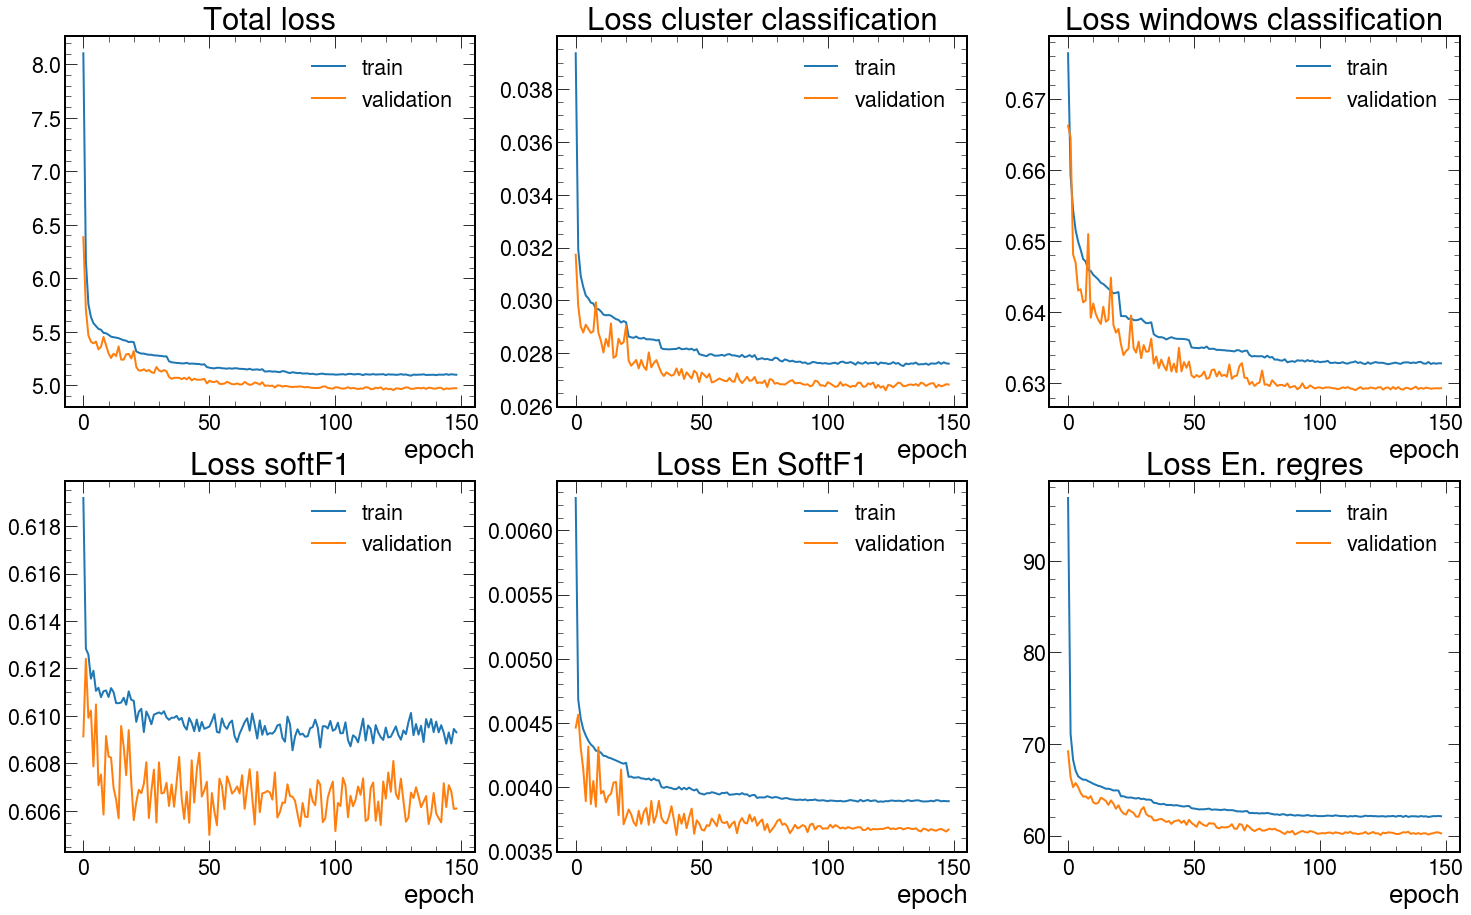

In [24]:
f, ((ax1, ax2, ax3),(ax4, ax6, ax7)) = plt.subplots(2, 3, figsize=(25, 15))

ax1.plot(ret.history["loss"], label="train", linewidth=2)
ax1.plot(ret.history["val_loss"],label="validation", linewidth=2)
ax1.set_title("Total loss")
ax1.set_xlabel("epoch")
ax1.legend()

ax2.plot(ret.history["loss_clusters"], label="train", linewidth=2)
ax2.plot(ret.history["val_loss_clusters"],label="validation", linewidth=2)
ax2.set_title("Loss cluster classification")
ax2.set_xlabel("epoch")
ax2.legend()

ax3.plot(ret.history["loss_windows"], label="train", linewidth=2)
ax3.plot(ret.history["val_loss_windows"],label="validation", linewidth=2)
ax3.set_title("Loss windows classification")
ax3.set_xlabel("epoch")
ax3.legend()

ax4.plot(ret.history["loss_softF1"], label="train", linewidth=2)
ax4.plot(ret.history["val_loss_softF1"],label="validation", linewidth=2)
ax4.set_title("Loss softF1")
ax4.set_xlabel("epoch")
ax4.legend()

ax5.plot(ret.history["loss_en_resol"], label="train", linewidth=2)
ax5.plot(ret.history["val_loss_en_resol"],label="validation", linewidth=2)
ax5.set_title("Loss En resolution")
ax5.set_xlabel("epoch")
ax5.legend()

ax6.plot(ret.history["loss_en_softF1"], label="train", linewidth=2)
ax6.plot(ret.history["val_loss_en_softF1"],label="validation", linewidth=2)
ax6.set_title("Loss En SoftF1")
ax6.set_xlabel("epoch")
ax6.legend()

ax7.plot(ret.history["loss_en_regr"], label="train", linewidth=2)
ax7.plot(ret.history["val_loss_en_regr"],label="validation", linewidth=2)
ax7.set_title("Loss En. regres")
ax7.set_xlabel("epoch")
ax7.legend()

f.savefig(outdir + "/train_loss.png")


### Test loss

In [22]:
X,y_true, weight = tf_data.get(ds_test)

In [23]:
y_pred = model(X)

In [29]:
huber_loss(true_en_gen, calib_pred_en, 5, weight)

<tf.Tensor: shape=(512,), dtype=float32, numpy=
array([4.32669856e-02, 1.65593338e+01, 1.84165955e+01, 6.93726683e+00,
       4.73029041e+00, 4.13307571e+00, 2.50770935e+02, 1.22367706e+02,
       2.68272781e+01, 5.02706349e-01, 2.39473724e+01, 3.01573682e+00,
       3.41978431e-01, 2.12139893e+01, 1.79401970e+01, 3.52403335e-02,
       6.46475983e+00, 2.24501495e+02, 9.45971680e+01, 1.41807861e+02,
       2.20625305e+01, 9.97996271e-01, 2.82393799e+02, 3.28927696e-01,
       4.88209724e+00, 8.32234192e+01, 1.47835732e+01, 1.57727814e+01,
       2.16219177e+02, 1.66248167e+00, 5.92983093e+02, 1.04455414e+02,
       2.25272506e-01, 1.17539726e-01, 9.04288483e+01, 4.97194426e-03,
       3.79153137e+02, 1.61109924e+01, 3.84396791e+00, 2.05503035e+00,
       2.17883301e+01, 4.77015305e+01, 8.53880882e+00, 1.39106065e-01,
       3.36060486e+02, 3.23530579e+01, 1.24206269e+00, 5.16378784e+01,
       5.25619090e-01, 5.91772699e+00, 4.93536055e-01, 3.05503392e+00,
       3.26979828e+01, 2.8660

### Layers inspection

In [192]:
model.layers

In [193]:
graphbuild = model.layers[0]

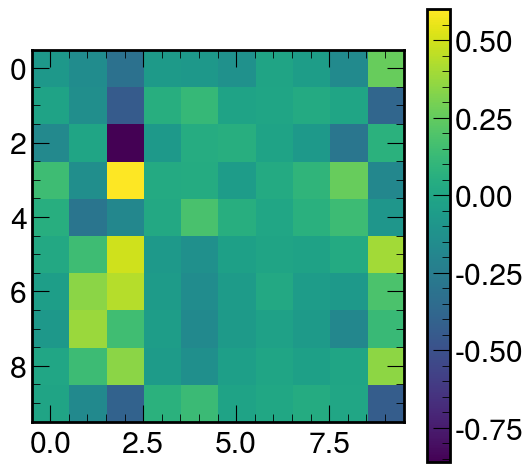

In [194]:
plotM(graphbuild.rechitsGCN.weights[2].numpy())